## [Linear models - quantile regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.QuantileRegressor.html#sklearn.linear_model.QuantileRegressor)
- Predicts $y(w,X) = Xw$ for a given quantile.
- The weights ($w$) are found via __[pinball_loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_pinball_loss.html#sklearn.metrics.mean_pinball_loss)__, aka linear loss.
- L1 penalty controlled by `alpha`.
- Much more robust to outliers than squared error-based mean estimation.
- Useful for predicting intervals (instead of points).

### [example](https://scikit-learn.org/stable/auto_examples/linear_model/plot_quantile_regression.html)

In [1]:
# two synthetic datasets

import numpy as np
rng = np.random.RandomState(42)
x           = np.linspace(start=0, stop=10, num=100)
X           = x[:, np.newaxis]
y_true_mean = 10 + 0.5 * x

In [2]:
# 1) add heteroscedastic normal noise
# 2) add asymmetric pareto noise

y_normal = y_true_mean + rng.normal(loc=0, 
                                    scale=0.5+0.5*x, 
                                    size=x.shape[0])
a = 5
y_pareto = y_true_mean + 10 * (rng.pareto(a, size=x.shape[0]) 
                               - 1/(a-1))

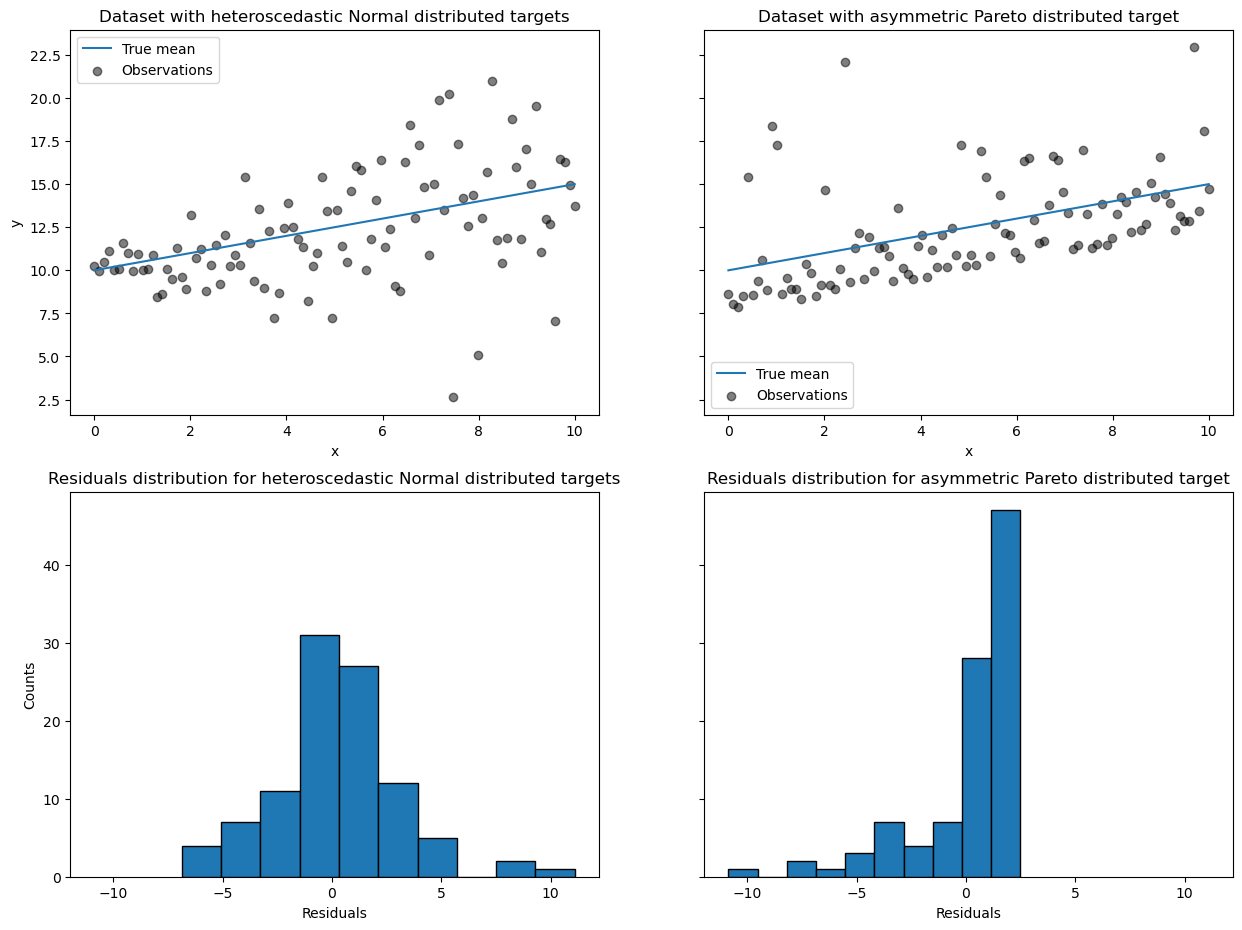

In [3]:
# plot
import matplotlib.pyplot as plt

_, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11), sharex="row", sharey="row")

axs[0, 0].plot(x, y_true_mean, label="True mean")
axs[0, 0].scatter(x, y_normal, color="black", alpha=0.5, label="Observations")
axs[1, 0].hist(y_true_mean - y_normal, edgecolor="black")


axs[0, 1].plot(x, y_true_mean, label="True mean")
axs[0, 1].scatter(x, y_pareto, color="black", alpha=0.5, label="Observations")
axs[1, 1].hist(y_true_mean - y_pareto, edgecolor="black")

axs[0, 0].set_title("Dataset with heteroscedastic Normal distributed targets")
axs[0, 1].set_title("Dataset with asymmetric Pareto distributed target")
axs[1, 0].set_title(
    "Residuals distribution for heteroscedastic Normal distributed targets"
)
axs[1, 1].set_title("Residuals distribution for asymmetric Pareto distributed target")
axs[0, 0].legend()
axs[0, 1].legend()
axs[0, 0].set_ylabel("y")
axs[1, 0].set_ylabel("Counts")
axs[0, 1].set_xlabel("x")
axs[0, 0].set_xlabel("x")
axs[1, 0].set_xlabel("Residuals")
_ = axs[1, 1].set_xlabel("Residuals")

- Heteroscedastic normal distributed target: the noise variance increases with the value of feature x.
- Asymmetric pareto distributed target: positive residuals are bounded.
- These noisy targets __make LinearRegression less efficient__ (we need more data to get stable results).
- Also: large outliers have huge impacts on the fitted coefficients.
- In this asymmetric setting, the median or different quantiles give additional insights. Also: median estimation is more robust to outliers and heavy tailed distributions. Note: extreme quantiles are estimated by very few data points. 95% quantile are more or less estimated by the 5% largest values and thus also a bit sensitive outliers.

### [quantile regression fit](https://scikit-learn.org/stable/auto_examples/linear_model/plot_quantile_regression.html#fitting-a-quantileregressor)
- We want to estimate the conditional median, also 5% & 95% quantiles. We will build three linear models - one for each quantile.

In [4]:
from sklearn.utils.fixes import parse_version as PV 
from sklearn.utils.fixes import sp_version as SV

# Avoids incompatibility if older SciPy version.
# You should use `solver="highs"` with recent version of SciPy.
solver = "highs" if SV >= PV("1.6.0") else "interior-point"

In [5]:
from sklearn.linear_model import QuantileRegressor as QR

quantiles = [0.05, 0.5, 0.95]
predictions = {}
out_bounds_predictions = np.zeros_like(y_true_mean, dtype=np.bool_)
for quantile in quantiles:
    qr = QR(quantile=quantile, alpha=0, solver=solver)
    y_pred = qr.fit(X, y_normal).predict(X)
    predictions[quantile] = y_pred

    if quantile == min(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred >= y_normal
        )
    elif quantile == max(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred <= y_normal
        )

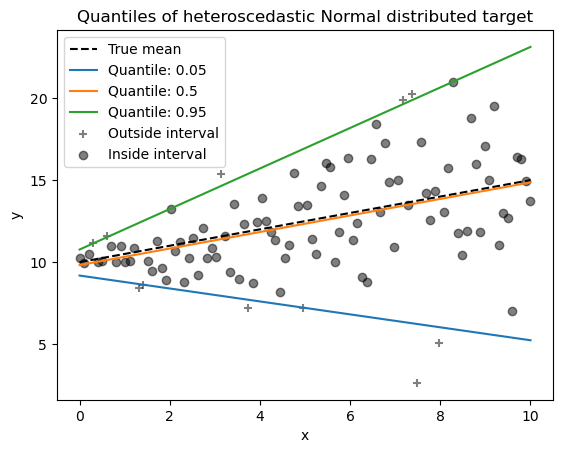

In [6]:
# plot 

plt.plot(X, y_true_mean, color="black", linestyle="dashed", label="True mean")

for quantile, y_pred in predictions.items():
    plt.plot(X, y_pred, label=f"Quantile: {quantile}")

plt.scatter(
    x[out_bounds_predictions],
    y_normal[out_bounds_predictions],
    color="black",
    marker="+",
    alpha=0.5,
    label="Outside interval",
)
plt.scatter(
    x[~out_bounds_predictions],
    y_normal[~out_bounds_predictions],
    color="black",
    alpha=0.5,
    label="Inside interval",
)

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
_ = plt.title("Quantiles of heteroscedastic Normal distributed target")

- Since the noise is still normally distributed & symmetric, the true conditional mean and the true conditional median coincide.
- Notice the effect of increasing noise variance on the 5% and 95% quantiles: the slopes of those quantiles are very different and the interval between them becomes wider with increasing x.
- To get more insight of the 5% & 95% quantile estimators, you can count the #samples above and below the predicted quantiles ("+" in the above plot).
- Repeat the experiment using the asymmetric Pareto distributed target.

In [7]:
quantiles = [0.05, 0.5, 0.95]
predictions = {}
out_bounds_predictions = np.zeros_like(y_true_mean, dtype=np.bool_)
for quantile in quantiles:
    qr = QR(quantile=quantile, alpha=0, solver=solver)
    y_pred = qr.fit(X, y_pareto).predict(X)
    predictions[quantile] = y_pred

    if quantile == min(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred >= y_pareto
        )
    elif quantile == max(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred <= y_pareto
        )

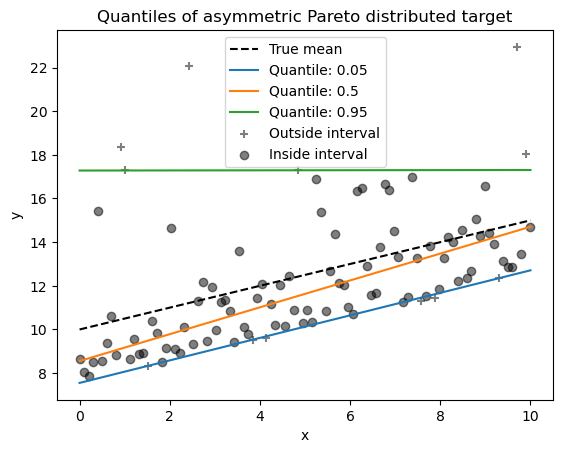

In [8]:
plt.plot(X, y_true_mean, color="black", linestyle="dashed", label="True mean")

for quantile, y_pred in predictions.items():
    plt.plot(X, y_pred, label=f"Quantile: {quantile}")

plt.scatter(
    x[out_bounds_predictions],
    y_pareto[out_bounds_predictions],
    color="black",
    marker="+",
    alpha=0.5,
    label="Outside interval",
)
plt.scatter(
    x[~out_bounds_predictions],
    y_pareto[~out_bounds_predictions],
    color="black",
    alpha=0.5,
    label="Inside interval",
)

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
_ = plt.title("Quantiles of asymmetric Pareto distributed target")

- Note the true mean and estimated conditional median are different due to noise asymmetry.
- Note each quantile model has different parameters to better fit the desired quantile. Ideally, all quantiles would be parallel - which would be more obvious with more data points or less extreme quantiles, e.g. 10% and 90%.

### [Quantile vs Linear regression](https://scikit-learn.org/stable/auto_examples/linear_model/plot_quantile_regression.html#comparing-quantileregressor-and-linearregression)
- Linar Regression uses __least squares__ to find MSE.
- Quantile Regression (`quantile=0.5`) minimizes MAE instead.
- Below: find training errors using both MSE and MAE. Use asymmetric Pareto distribution to make things interesting.

In [10]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

lr = LR()
qr = QR(quantile=0.5, alpha=0, solver=solver)

y_pred_lr = lr.fit(X, y_pareto).predict(X)
y_pred_qr = qr.fit(X, y_pareto).predict(X)

print(f"""Training error (in-sample performance)
    {lr.__class__.__name__}:
    mae = {MAE(y_pareto, y_pred_lr):.3f}
    mse = {MSE(y_pareto, y_pred_lr):.3f}
    {qr.__class__.__name__}:
    mae = {MAE(y_pareto, y_pred_qr):.3f}
    mse = {MSE(y_pareto, y_pred_qr):.3f}
    """)

Training error (in-sample performance)
    LinearRegression:
    mae = 1.805
    mse = 6.486
    QuantileRegressor:
    mae = 1.670
    mse = 7.025
    


- On the training set:
  - MAE is lower for QuantileRegressor than LinearRegression.
  - MSE is lower for LinearRegression than QuantileRegressor.
  - This confirms MAE is the loss minimized by QuantileRegressor & MSE is the loss minimized by LinearRegression.

- We can make a similar evaluation by looking at the test error obtained by cross-validation.

In [11]:
from sklearn.model_selection import cross_validate as CV

cv_results_lr = CV(
    lr,
    X,
    y_pareto,
    cv=3,
    scoring=["neg_mean_absolute_error", "neg_mean_squared_error"],
)
cv_results_qr = CV(
    qr,
    X,
    y_pareto,
    cv=3,
    scoring=["neg_mean_absolute_error", "neg_mean_squared_error"],
)
print(f"""Test error (cross-validated performance)
    {lr.__class__.__name__}:
    mae = {-cv_results_lr["test_neg_mean_absolute_error"].mean():.3f}
    mse = {-cv_results_lr["test_neg_mean_squared_error"].mean():.3f}
    {qr.__class__.__name__}:
    mae = {-cv_results_qr["test_neg_mean_absolute_error"].mean():.3f}
    mse = {-cv_results_qr["test_neg_mean_squared_error"].mean():.3f}
    """)

Test error (cross-validated performance)
    LinearRegression:
    mae = 1.732
    mse = 6.690
    QuantileRegressor:
    mae = 1.679
    mse = 7.129
    
